<a href="https://colab.research.google.com/github/smc395/ics691_big_data_project/blob/main/Ray_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
This tutorial is for ICS691 Big Data Analytics Fall 2022 semester project. I will be evaluating [Ray](https://www.ray.io/), an open-source unified compute framework.

# References
1. [Ray Documentation](https://docs.ray.io/en/latest/ray-overview/index.html)
2. [Downloading Kaggle datasets directly into Google Colab](https://towardsdatascience.com/downloading-kaggle-datasets-directly-into-google-colab-c8f0f407d73a)
3. [Kaggle Flight Delay Dataset](https://www.kaggle.com/datasets/robikscube/flight-delay-dataset-20182022)

## Getting Started

In [1]:
# Install dependencies
%%capture --no-display
!pip install -U "pyarrow<7.0.0"
!pip install ray
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 25.6 MB 1.4 MB/s 
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 9.0.0
    Uninstalling pyarrow-9.0.0:
      Successfully uninstalled pyarrow-9.0.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 58.9 MB 1.1 MB/s 
     |████████████████████████████████| 8.8 MB 59.7 MB/s 
     |████████████████████████████████| 468 kB 68.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [70]:
# Import dependencies and create Ray cluster
import os
import pyarrow as pa
import matplotlib.pyplot as plt

import ray
ray.init()

2022-12-07 07:33:56,313	WARNING services.py:1922 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 3099783168 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=4.04gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2022-12-07 07:33:56,435	INFO worker.py:1528 -- Started a local Ray instance.


Python version:,3.8.15
Ray version:,2.1.0


In [ ]:
ds = ray.data.read_parquet([
    "s3://anonymous@air-example-data/ursa-labs-taxi-data/downsampled_2009_01_data.parquet",
    "s3://anonymous@air-example-data/ursa-labs-taxi-data/downsampled_2009_02_data.parquet"
])

Parquet Files Sample: 100%|██████████| 2/2 [00:07<00:00,  3.80s/it]


In [3]:
# This will connect the Colab notebook to your Google Drive account
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [4]:
os.environ['KAGGLE_CONFIG_DIR'] = '../gdrive/MyDrive/kaggle'
os.chdir('../gdrive/MyDrive/kaggle')

'/content'

In [40]:
!kaggle datasets download -d robikscube/flight-delay-dataset-20182022

100% 3.72G/3.73G [00:28<00:00, 170MB/s]
100% 3.73G/3.73G [00:28<00:00, 142MB/s]


In [10]:
zip_path = '/gdrive/MyDrive/kaggle/flight-delay-dataset-20182022.zip'

In [12]:
if not os.path.exists('/content/flight_data'):
  os.mkdir('/content/flight_data')
os.chdir('/content/flight_data')
!cp '{zip_path}' .

In [13]:
!unzip -q 'flight-delay-dataset-20182022.zip'

In [49]:
#parquet_file_paths = [
#'/content/flight_data/Combined_Flights_2018.parquet'
#,'/content/flight_data/Combined_Flights_2019.parquet'
#,'/content/flight_data/Combined_Flights_2020.parquet'
#,'/content/flight_data/Combined_Flights_2021.parquet'
#,'/content/flight_data/Combined_Flights_2022.parquet'
#]

['Combined_Flights_2021.csv',
 'Combined_Flights_2018.csv',
 'Airlines.csv',
 'Combined_Flights_2020.csv',
 'raw',
 'readme.md',
 'Combined_Flights_2019.csv',
 'Combined_Flights_2018.parquet',
 'Combined_Flights_2021.parquet',
 'Combined_Flights_2019.parquet',
 'Combined_Flights_2022.parquet',
 '.ipynb_checkpoints',
 'Combined_Flights_2020.parquet',
 'flight-delay-dataset-20182022.zip',
 'readme.html',
 'Combined_Flights_2022.csv']

In [71]:
# Read in flight data in parallel
#flights = ray.data.read_parquet(parquet_file_paths, parallelism=5).repartition(5)
flights = ray.data.read_parquet('/content/flight_data/Combined_Flights_2018.parquet', parallelism=2).repartition(2)

Parquet Files Sample:   0%|          | 0/1 [00:00<?, ?it/s]
2022-12-07 07:35:13,311	WARNING read_api.py:285 -- ⚠️  The blocks of this dataset are estimated to be 5.0x larger than the target block size of 512 MiB. This may lead to out-of-memory errors during processing. Consider reducing the size of input files or using `.repartition(n)` to increase the number of dataset blocks.
Parquet Files Sample: 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]
(raylet) Spilled 2862 MiB, 1 objects, write throughput 111 MiB/s. Set RAY_verbose_spill_logs=0 to disable this message.
Repartition:   0%|          | 0/2 [00:00<?, ?it/s](raylet) Spilled 4285 MiB, 3 objects, write throughput 87 MiB/s.
(raylet) Spilled 8570 MiB, 5 objects, write throughput 110 MiB/s.
Repartition: 100%|██████████| 2/2 [01:13<00:00, 36.60s/it]


In [73]:
airlines = ray.data.read_csv('/content/flight_data/Airlines.csv')

In [74]:
flights.count()

5689512

In [75]:
flights.schema()

FlightDate: timestamp[us]
Airline: string
Origin: string
Dest: string
Cancelled: bool
Diverted: bool
CRSDepTime: int64
DepTime: double
DepDelayMinutes: double
DepDelay: double
ArrTime: double
ArrDelayMinutes: double
AirTime: double
CRSElapsedTime: double
ActualElapsedTime: double
Distance: double
Year: int64
Quarter: int64
Month: int64
DayofMonth: int64
DayOfWeek: int64
Marketing_Airline_Network: string
Operated_or_Branded_Code_Share_Partners: string
DOT_ID_Marketing_Airline: int64
IATA_Code_Marketing_Airline: string
Flight_Number_Marketing_Airline: int64
Operating_Airline: string
DOT_ID_Operating_Airline: int64
IATA_Code_Operating_Airline: string
Tail_Number: string
Flight_Number_Operating_Airline: int64
OriginAirportID: int64
OriginAirportSeqID: int64
OriginCityMarketID: int64
OriginCityName: string
OriginState: string
OriginStateFips: int64
OriginStateName: string
OriginWac: int64
DestAirportID: int64
DestAirportSeqID: int64
DestCityMarketID: int64
DestCityName: string
DestState: st

# Create an airline Actor
# Create Tasks to
1. Calculate the percentage of cancelled flights
2. The average delay time
3. The average distance flown
4. The number of flights to a destination

In [48]:
# turn this class into an Actor
@ray.remote
class Airline:
  def __init__(self, code, name):
    self.code = code
    self.name = name
    self.i = 0

  def get_code(self):
    return self.code

  def get_name(self):
    return self.name

  def incr(self, value):
    self.i += value

In [82]:
# get the top 4 airlines from the key
r = airlines.take(4)
r

[ArrowRow({'Code': '02Q', 'Description': 'Titan Airways'}),
 ArrowRow({'Code': '04Q', 'Description': 'Tradewind Aviation'}),
 ArrowRow({'Code': '05Q', 'Description': 'Comlux Aviation, AG'}),
 ArrowRow({'Code': '06Q', 'Description': 'Master Top Linhas Aereas Ltd.'})]

In [51]:
# for each airline from the 4 we took, create the Airline actor
air = []
for a in r:
  air.append(Airline.remote(a['Code'], a['Description']))
air

[Actor(Airline, 3b81f491cafd376fa695768c01000000),
 Actor(Airline, 4e91ad408fbfc2adb7141f8e01000000),
 Actor(Airline, 557c33fda7c8349c103ca26e01000000),
 Actor(Airline, fa4e3ce99dfef5288b6b9cc601000000)]

2022-12-07 07:05:46,395	WARNING worker.py:1839 -- WARNING: 16 PYTHON worker processes have been started on node: 815a248a2ff2a47f71c6d8e30bd32e4641b1f38cc5c46521f95d1adf with address: 172.28.0.12. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).


In [ ]:
# for each Airline actor, return the name asynchronosly
for b in air:
  airline_name = b.get_name.remote()
  print(ray.get(airline_name))

In [79]:
# create a task that will count the number of flight records by airline asynchronosly
@ray.remote
def datacount():
  return flights.groupby('Airline').count()

In [80]:
# create an object reference of the asynchronos job
obj_ref = datacount.remote()

Sort Sample:   0%|          | 0/2 [00:00<?, ?it/s]


In [85]:
# execute the object reference, sort the count output by descending, then take the top 10
top = ray.get(obj_ref).sort('count()', descending=True).take(10)

Shuffle Reduce: 100%|██████████| 2/2 [00:00<00:00, 12.13it/s]


In [91]:
# get the top 10 airline and flight count
x = []
y = []
for airline in top:
  x.append(airline['Airline'])
  y.append(airline['count()'] / 1000)

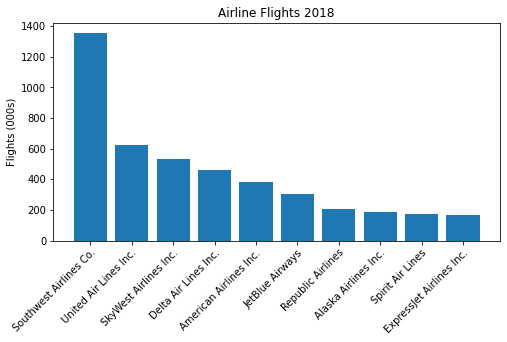

In [102]:
# plot the top 10 flight counts by airline
fig, ax = plt.subplots(figsize=(8,4))

ax.bar(x, y)

ax.set_ylabel('Flights (000s)')
ax.set_title('Airline Flights 2018')
plt.setp( ax.xaxis.get_majorticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.show()